In [2]:
import numpy as np
import pandas as pd
import math
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.preprocessing import MinMaxScaler

In [3]:
df = pd.read_csv("data.csv")

In [73]:
cases_col = "cases"
cols = [cases_col, "tsa", "visits_hotels", "visits_restaurants", "visits_retail", "visits_personal_care", "visits_gyms", "visits_health", "temperature", "flu", "tests", "hospitalized"]
state_cols = ["density", "svi"]

In [335]:
X_series = df.copy()
wind = 14
num_classes = 10
min_max_scaler = MinMaxScaler()
X_series[[cases_col]] = X_series[[cases_col]].clip(lower=0)
for col in cols + state_cols:
    X_series[[col]] = min_max_scaler.fit_transform(X_series[[col]])
X = np.empty((len(df) - wind - 14, wind, len(cols)))
y = np.empty((len(df) - wind - 14, 14))
include_set = []
include2_set = []
last_state = ""
j = 0
state_i = 0
for i in range(len(df) - wind - 14):
    X[i] = np.array(X_series[cols][i:i+wind])
    y[i] = np.array(X_series[cases_col][i+wind:i+wind+14])
    include_set.append(len(X_series["state"][i:i+wind+14].unique()) == 1)
    include2_set.append(not include_set[i] and len(X_series["state"][i:i+wind].unique()) == 1 and len(X_series["state"][i+wind:i+wind+14].unique()) == 1)
    if include_set[i] and X_series["state"][i] != last_state:
        last_state = X_series["state"][i]
        print("%d %d %s" % (j, state_i, last_state))
        state_i += 1
    if include_set[i]:
        j += 1
X_u = X[include2_set]
y_u = y[include2_set]
X = X[include_set]
y = y[include_set]
    
X_state = np.array(X_series[state_cols][(wind-1):-15])
X_su = X_state[include2_set]
X_state = X_state[include_set]

0 0 Washington
268 1 Illinois
536 2 California
804 3 Arizona
1072 4 Massachusetts
1340 5 Wisconsin
1608 6 Texas
1876 7 Nebraska
2144 8 Utah
2412 9 Oregon
2680 10 Florida
2948 11 New York
3216 12 Rhode Island
3484 13 Georgia
3751 14 New Hampshire
4018 15 North Carolina
4284 16 New Jersey
4549 17 Colorado
4813 18 Maryland
5077 19 Nevada
5341 20 Tennessee
5605 21 Hawaii
5868 22 Indiana
6131 23 Kentucky
6394 24 Minnesota
6657 25 Oklahoma
6920 26 Pennsylvania
7183 27 South Carolina
7446 28 District of Columbia
7708 29 Kansas
7970 30 Missouri
8232 31 Vermont
8494 32 Virginia
8756 33 Connecticut
9017 34 Iowa
9278 35 Louisiana
9538 36 Ohio
9798 37 Michigan
10057 38 South Dakota
10316 39 Arkansas
10574 40 Delaware
10832 41 Mississippi
11090 42 New Mexico
11348 43 North Dakota
11606 44 Wyoming
11864 45 Alaska
12121 46 Maine
12378 47 Alabama
12634 48 Idaho
12890 49 Montana
13146 50 West Virginia


In [336]:
X_train, X_test, X_state_train, X_state_test, y_train, y_test = train_test_split(X, X_state, y, test_size=0.25, shuffle=False)

In [325]:
def construct_model():
    feat_inputs = tf.keras.Input(shape=(wind, 12))
    state_inputs = tf.keras.Input(shape=(2))
    lstm = tf.keras.layers.LSTM(60, return_sequences=True, input_shape=(wind, 12))
    lstm_out = lstm(feat_inputs)
    dropout2 = tf.keras.layers.Dropout(0.2)
    dropout2_out = dropout2(lstm_out)
    lstm2 = tf.keras.layers.LSTM(60, return_sequences=True)
    lstm2_out = lstm2(dropout2_out)
    dense1 = tf.keras.layers.Dense(3)
    dense1_out = dense1(state_inputs)
    concat = tf.keras.layers.concatenate((tf.keras.layers.Flatten()(lstm2_out), dense1_out), axis=1)
    dropout = tf.keras.layers.Dropout(0.2)
    dropout_out = dropout(concat)
    dense2 = tf.keras.layers.Dense(14, activation="relu")
    dense2_out = dense2(dropout_out)
    model = tf.keras.Model(inputs=(feat_inputs, state_inputs), outputs=dense2_out, name="model")
    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanSquaredError(), tf.metrics.MeanAbsoluteError()])
    return model

In [326]:
model = construct_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_40 (InputLayer)           [(None, 14, 12)]     0                                            
__________________________________________________________________________________________________
lstm_35 (LSTM)                  (None, 14, 60)       17520       input_40[0][0]                   
__________________________________________________________________________________________________
dropout_30 (Dropout)            (None, 14, 60)       0           lstm_35[0][0]                    
__________________________________________________________________________________________________
lstm_36 (LSTM)                  (None, 14, 60)       29040       dropout_30[0][0]                 
______________________________________________________________________________________________

In [327]:
model.fit((X_train, X_state_train), y_train, epochs=30, batch_size=16, validation_data=((X_test, X_state_test), y_test))

Epoch 1/30
628/628 [==============================] - 6s 7ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0216 - val_loss: 6.5325e-05 - val_mean_squared_error: 6.5325e-05 - val_mean_absolute_error: 0.0056
Epoch 2/30
628/628 [==============================] - 4s 6ms/step - loss: 5.3882e-04 - mean_squared_error: 5.3882e-04 - mean_absolute_error: 0.0127 - val_loss: 6.4363e-05 - val_mean_squared_error: 6.4363e-05 - val_mean_absolute_error: 0.0053
Epoch 3/30
628/628 [==============================] - 4s 6ms/step - loss: 4.2648e-04 - mean_squared_error: 4.2648e-04 - mean_absolute_error: 0.0115 - val_loss: 3.0956e-05 - val_mean_squared_error: 3.0956e-05 - val_mean_absolute_error: 0.0038
Epoch 4/30
628/628 [==============================] - 4s 6ms/step - loss: 3.7053e-04 - mean_squared_error: 3.7053e-04 - mean_absolute_error: 0.0107 - val_loss: 2.8418e-05 - val_mean_squared_error: 2.8418e-05 - val_mean_absolute_error: 0.0033
Epoch 5/30
628/628 [====================

In [426]:
a = 10574
b = 10832
e_s = model.predict((X[a:b], X_state[a:b]))
y_s = y[a:b]

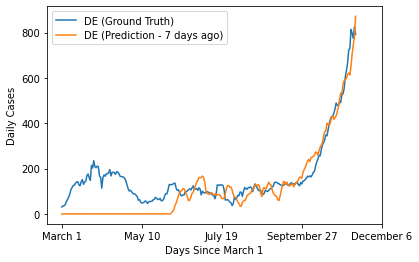

In [427]:
import matplotlib.pyplot as plt
mi = 0
ma = np.max(df["cases"])
r = ma - mi
plt.plot(y_s[:,6] * r + mi)[0].set_label("DE (Ground Truth)")
plt.plot(e_s[:,6] * r + mi)[0].set_label("DE (Prediction - 7 days ago)")
plt.xlabel("Days Since March 1")
plt.ylabel("Daily Cases")
plt.xticks(range(0, len(cases_fl), 70), labels=("March 1", "May 10", "July 19", "September 27", "December 6"))
plt.legend()
plt.show()

In [366]:
ex_i = 16
e_u = model.predict((X_u, X_su))
e_i = model.predict((np.array([X_u[ex_i]]), np.array([X_su[ex_i]])))[0]
y_i = y_u[ex_i]
print(X_u[ex_i][13][0] * r + mi)

4568.857142857143


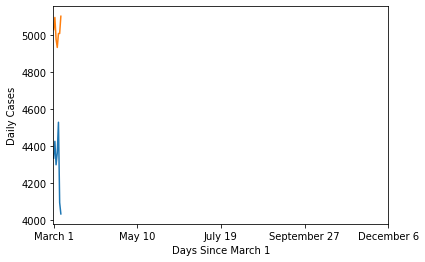

In [416]:
next_days = [4336, 4427, 4300, 4364, 4530, 4095, 4034]
plt.plot(next_days)[0].set_label("WY (Ground Truth)")
plt.plot(e_i[:7] * r + mi)[0].set_label("WY (Predicted)")
plt.xlabel("Days Since March 1")
plt.ylabel("Daily Cases")
plt.xticks(range(0, len(cases_fl), 70), labels=("March 1", "May 10", "July 19", "September 27", "December 6"))
plt.show()

In [153]:
y

array([[0.02118512, 0.02145075, 0.02149667, ..., 0.02592718, 0.02719304,
        0.02814407],
       [0.02145075, 0.02149667, 0.02169015, ..., 0.02719304, 0.02814407,
        0.02944601],
       [0.02149667, 0.02169015, 0.02208696, ..., 0.02814407, 0.02944601,
        0.02953127],
       ...,
       [0.04280313, 0.04477406, 0.04566935, ..., 0.04779442, 0.04693849,
        0.0482601 ],
       [0.04477406, 0.04566935, 0.04660727, ..., 0.04693849, 0.0482601 ,
        0.04932263],
       [0.04566935, 0.04660727, 0.04646297, ..., 0.0482601 , 0.04932263,
        0.04915866]])

In [87]:
y_s

array([[0.02944601, 0.02953127, 0.02869502, ..., 0.02934762, 0.02901312,
        0.02838019],
       [0.02953127, 0.02869502, 0.02928531, ..., 0.02901312, 0.02838019,
        0.02739964],
       [0.02869502, 0.02928531, 0.03051182, ..., 0.02838019, 0.02739964,
        0.02652403],
       ...,
       [0.02464164, 0.02637974, 0.02745539, ..., 0.04127819, 0.04301957,
        0.04421656],
       [0.02637974, 0.02745539, 0.02860319, ..., 0.04301957, 0.04421656,
        0.04599729],
       [0.02745539, 0.02860319, 0.03113491, ..., 0.04421656, 0.04599729,
        0.04805349]])

In [338]:
model.save("lstmpred2")

INFO:tensorflow:Assets written to: lstmpred2/assets


INFO:tensorflow:Assets written to: lstmpred2/assets


In [252]:
0.0040 * r

174.2462857142857

In [375]:
cases_nj = df[df["state"] == "New Jersey"]["cases"].reset_index()["cases"]
cases_ny = df[df["state"] == "New York"]["cases"].reset_index()["cases"]
cases_fl = df[df["state"] == "Florida"]["cases"].reset_index()["cases"]

In [376]:
nj_last14 = e_u[16] * r + mi
ny_last14 = e_u[11] * r + mi
fl_last14 = e_u[10] * r + mi

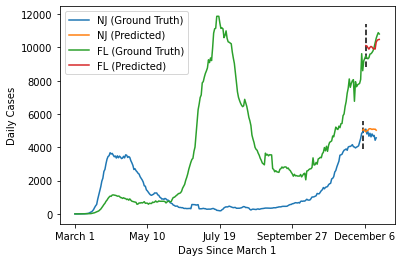

In [413]:
plt.plot(cases_nj)[0].set_label("NJ (Ground Truth)")
plt.plot(list(range(len(cases_nj) - 14, len(cases_nj))), nj_last14)[0].set_label("NJ (Predicted)")
plt.vlines(x=len(cases_nj) - 14, ymin=min(cases_nj[-14:]) - 500, ymax=max(cases_nj[-14:]) + 500, colors='k', linestyles='dashed')
#plt.plot(cases_ny)[0].set_label("NY (Ground Truth)")
#plt.plot(list(range(len(cases_nj) - 14, len(cases_nj))), ny_last14)[0].set_label("NY (Predicted)")
plt.plot(cases_fl)[0].set_label("FL (Ground Truth)")
plt.plot(list(range(len(cases_fl) - 14, len(cases_fl))), fl_last14)[0].set_label("FL (Predicted)")
plt.vlines(x=len(cases_fl) - 14, ymin=min(cases_fl[-14:]) - 500, ymax=max(cases_fl[-14:]) + 500, colors='k', linestyles='dashed')
plt.xlabel("Days Since March 1")
plt.ylabel("Daily Cases")
plt.xticks(range(0, len(cases_fl), 70), labels=("March 1", "May 10", "July 19", "September 27", "December 6"))
plt.legend()
plt.show()

In [421]:
0.0023 * r

98.2445